In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from encode_data import *
from midi_data import *

In [3]:
from tqdm import tqdm
import pandas as pd
from data_sources import process_parallel, transform_csv_row

In [4]:
from collections import Counter

## Encode music21 stream to text representation 

This notebook uses a full component format 
- measure separators, instruments, and separated octaves
- Format: note, octave, action type, instrument
- note repr: nG# o4 t1 i0

### Load midi data

In [5]:
version = 'v8'
data_path = Path('data/midi')
version_path = data_path/version

In [6]:
source_dir = 'midi_npz'

out_dir = 'midi_encode/np/shortdur'
source_csv = version_path/source_dir/f'{source_dir}.csv'
out_csv = version_path/out_dir/f'midi_encode.csv'

In [7]:
df = pd.read_csv(source_csv); df.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,4,15,18,19,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,inferred_offset,song_url,instruments,ht_mode,midi_title,title,seconds,midi,inferred_key,quarter_length,...,ht_key,ht_time_signature,bpm,section,parts,genres,mxl,midi_transform,midi_npz,midi_npz_timesteps
0,0.0,https://www.hooktheory.com/theorytab/view/wayn...,Piano,1.0,yu-gi-oh,yu-gi-oh-theme-song,25.411765,midi_sources/hooktheory/pianoroll/w/wayne-shar...,C major,36.0,...,C,3.0,85.0,intro,"intro,chorus",NaN,NaN,midi_transform/hooktheory/pianoroll/w/wayne-sh...,midi_npz/hooktheory/pianoroll/w/wayne-sharpe/y...,145.0
1,0.0,https://www.hooktheory.com/theorytab/view/wayn...,"Piano,Piano",1.0,yu-gi-oh3,yu-gi-oh-theme-song,15.000000,midi_sources/hooktheory/pianoroll/w/wayne-shar...,C major,32.0,...,C,4.0,128.0,chorus,"intro,chorus",NaN,NaN,midi_transform/hooktheory/pianoroll/w/wayne-sh...,midi_npz/hooktheory/pianoroll/w/wayne-sharpe/y...,129.0
2,5.0,https://www.hooktheory.com/theorytab/view/what...,"Piano,Piano",1.0,kiefer,kiefer,10.000000,midi_sources/hooktheory/pianoroll/w/what-a-day...,E minor,16.0,...,C,4.0,96.0,chorus,chorus,Jazz,NaN,midi_transform/hooktheory/pianoroll/w/what-a-d...,midi_npz/hooktheory/pianoroll/w/what-a-day/kie...,65.0
3,NaN,https://www.hooktheory.com/theorytab/view/weez...,NaN,1.0,My New Song,beverly-hills,NaN,midi_sources/hooktheory/pianoroll/w/weezer/bev...,NaN,NaN,...,C,4.0,NaN,intro-and-verse,intro-and-verse,NaN,NaN,NaN,NaN,NaN
4,0.0,https://www.hooktheory.com/theorytab/view/weez...,"Piano,Piano",1.0,Weezer - Fall Together,fall-together-,10.322581,midi_sources/hooktheory/pianoroll/w/weezer/fal...,A minor,16.0,...,C,4.0,93.0,chorus,chorus,Rock,NaN,midi_transform/hooktheory/pianoroll/w/weezer/f...,midi_npz/hooktheory/pianoroll/w/weezer/fall-to...,65.0


In [8]:
df_filtered = df.loc[df[source_dir].notna()]; df_filtered.shape

(162688, 25)

In [9]:
df_filter = (df_filtered.source != 'hooktheory') | (df_filtered.ht_time_signature == 4.0)
df_filtered = df_filtered.loc[df_filter]; df_filtered.shape

(160965, 25)

In [10]:
df_filtered = df_filtered.loc[df_filtered[f'{source_dir}_timesteps'] < 2e4]; df_filtered.shape

(160946, 25)

### Testing

In [11]:
files = df_filtered[source_dir].values; files[:10]

array(['midi_npz/hooktheory/pianoroll/w/wayne-sharpe/yu-gi-oh-theme-song/chorus_key_cmajor.npz',
       'midi_npz/hooktheory/pianoroll/w/what-a-day/kiefer/chorus_key_cmajor.npz',
       'midi_npz/hooktheory/pianoroll/w/weezer/fall-together-/chorus_key_cmajor.npz',
       'midi_npz/hooktheory/pianoroll/w/wavves/afraid-of-heights/intro_key_cmajor.npz',
       'midi_npz/hooktheory/pianoroll/w/weezer/buddy-holly/chorus_key_cmajor.npz',
       'midi_npz/hooktheory/pianoroll/w/weezer/the-greatest-man-that-ever-lived/solo-1_key_cmajor.npz',
       'midi_npz/hooktheory/pianoroll/w/weezer/falling-for-you/intro_key_cmajor.npz',
       'midi_npz/hooktheory/pianoroll/w/wavves/afraid-of-heights/verse_key_cmajor.npz',
       'midi_npz/hooktheory/pianoroll/w/weezer/buddy-holly/verse_key_cmajor.npz',
       'midi_npz/hooktheory/pianoroll/w/weezer/the-greatest-man-that-ever-lived/intro_key_cmajor.npz'], dtype=object)

In [12]:
file_path = version_path/files[3]

In [13]:
chordarr = load_chordarr(file_path)

In [14]:
stream = chordarr2stream(chordarr)

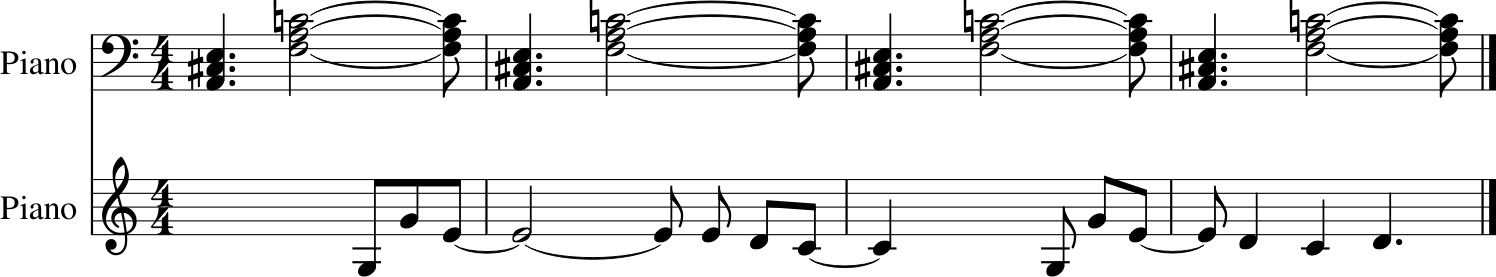

In [15]:
stream.show()

In [16]:
stream.show('midi')

In [17]:
chordarr.shape

(65, 2, 127)

In [40]:
chordarr[chordarr != 0]

array([ 6.,  6.,  6., -2., ..., -2., -2., -2., -2.])

In [35]:
seq[1]

[A2t-2, C#3t-2, E3t-2]

In [36]:
seq[2]

[A2t-2, C#3t-2, E3t-2]

In [18]:
seq = chordarr2seq(chordarr); seq

[[A2t6, C#3t6, E3t6],
 [A2t-2, C#3t-2, E3t-2],
 [A2t-2, C#3t-2, E3t-2],
 [A2t-2, C#3t-2, E3t-2],
 [A2t-2, C#3t-2, E3t-2],
 [A2t-2, C#3t-2, E3t-2],
 [F3t10, A3t10, C4t10],
 [F3t-2, A3t-2, C4t-2],
 [F3t-2, A3t-2, C4t-2],
 [F3t-2, A3t-2, C4t-2],
 [F3t-2, G3t2, A3t-2, C4t-2],
 [F3t-2, G3t-2, A3t-2, C4t-2],
 [F3t-2, A3t-2, C4t-2, G4t2],
 [F3t-2, A3t-2, C4t-2, G4t-2],
 [F3t-2, A3t-2, C4t-2, E4t12],
 [F3t-2, A3t-2, C4t-2, E4t-2],
 [A2t6, C#3t6, E3t6, E4t-2],
 [A2t-2, C#3t-2, E3t-2, E4t-2],
 [A2t-2, C#3t-2, E3t-2, E4t-2],
 [A2t-2, C#3t-2, E3t-2, E4t-2],
 [A2t-2, C#3t-2, E3t-2, E4t-2],
 [A2t-2, C#3t-2, E3t-2, E4t-2],
 [F3t10, A3t10, C4t10, E4t-2],
 [F3t-2, A3t-2, C4t-2, E4t-2],
 [F3t-2, A3t-2, C4t-2, E4t-2],
 [F3t-2, A3t-2, C4t-2, E4t-2],
 [F3t-2, A3t-2, C4t-2, E4t2],
 [F3t-2, A3t-2, C4t-2, E4t-2],
 [F3t-2, A3t-2, C4t-2, D4t2],
 [F3t-2, A3t-2, C4t-2, D4t-2],
 [F3t-2, A3t-2, C4t-2, C4t6],
 [F3t-2, A3t-2, C4t-2, C4t-2],
 [A2t6, C#3t6, E3t6, C4t-2],
 [A2t-2, C#3t-2, E3t-2, C4t-2],
 [A2t-2, C#3t-2,

In [55]:
music21.note.Note(24).octave

1

In [58]:
npenc.max(axis=0)

array([70, 15])

In [ ]:
def chordarr2npenc(chordarr, num_comps=2):
    # combine instruments
    ts_bos = pad_array([VALTBOS], PADDING_IDX, num_comps)
    result = [ts_bos]
    
    wait_count = 0
    for idx,timestep in enumerate(chordarr):
        enc_timestep = timestep2enc(timestep, num_comps)
        if len(enc_timestep) == 0:
            wait_count += 1
        else:
            # pitch, octave, duration, instrument
            ts_sep = pad_array([VALTSEP, wait_count], PADDING_IDX, num_comps)
            result.append(ts_sep)
            result.extend(enc_timestep)
            wait_count = 0
    return np.array(result, dtype=int) + ENC_OFFSET

# Note: not worrying about overlaps - as notes will still play. just look tied
# http://web.mit.edu/music21/doc/moduleReference/moduleStream.html#music21.stream.Stream.getOverlaps
def timestep2npenc(timestep, num_comps=2):
    # inst x pitch
    notes = []
    for i,n in zip(*timestep.nonzero()):
        d = timestep[i,n]
        if d <= 0: continue # only supporting short duration encoding for now
        notes.append([n,d,i])
        
    notes = sorted(notes, key=lambda x: x[0], reverse=True) # sort by note (highest to lowest)
    
    if num_comps == 2: return [n[:num_comps] for n in notes]
    return [[n%12, d, n//12, i][:num_comps] for n,d,i in notes]
    
    
### NOT FINISHED
# def npenc2chordarr(npenc):
#     npenc = npenc.copy() - ENC_OFFSET
#     max_vals = npenc.max(axis=0)
#     num_instruments = max_vals[-1] if len(npenc.shape)==4 else 0
#     note_range = 127
#     score_arr = np.zeros((len(npenc), num_instruments, note_range))
    # Problem: need to figure out the real zequence length. Not the shortened npenc length

In [78]:
npenc = seq2npenc(seq, num_comps=3)

In [79]:
npenc

array([[ 2,  0,  0],
       [ 1,  3,  0],
       [12,  9,  6],
       [ 4,  9,  7],
       ...,
       [ 3, 13,  8],
       [ 3,  7,  8],
       [ 1,  6,  0],
       [ 5,  9,  8]])

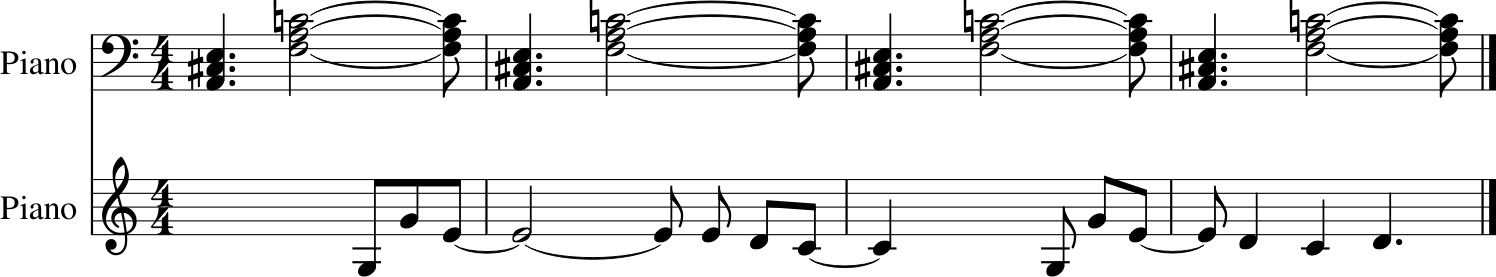

In [80]:
stream.show()

In [81]:
stream.show('midi')

In [82]:
dec_seq = npenc2seq(npenc)

In [83]:
dec_chordarr = seq2chordarr(dec_seq)

In [84]:
dec_stream = chordarr2stream(dec_chordarr)

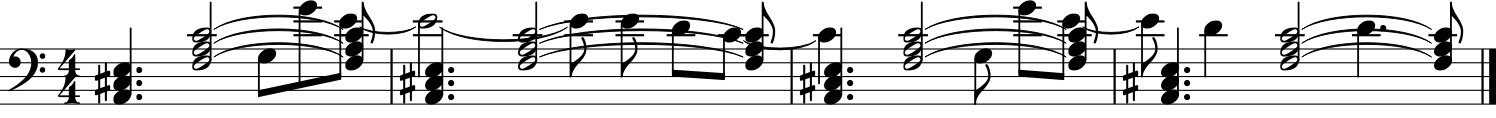

In [85]:
dec_stream.show()

In [86]:
dec_stream.show('midi')

In [87]:
seq

[[A2t6, C#3t6, E3t6],
 [A2t-2, C#3t-2, E3t-2],
 [A2t-2, C#3t-2, E3t-2],
 [A2t-2, C#3t-2, E3t-2],
 [A2t-2, C#3t-2, E3t-2],
 [A2t-2, C#3t-2, E3t-2],
 [F3t10, A3t10, C4t10],
 [F3t-2, A3t-2, C4t-2],
 [F3t-2, A3t-2, C4t-2],
 [F3t-2, A3t-2, C4t-2],
 [F3t-2, G3t2, A3t-2, C4t-2],
 [F3t-2, G3t-2, A3t-2, C4t-2],
 [F3t-2, A3t-2, C4t-2, G4t2],
 [F3t-2, A3t-2, C4t-2, G4t-2],
 [F3t-2, A3t-2, C4t-2, E4t12],
 [F3t-2, A3t-2, C4t-2, E4t-2],
 [A2t6, C#3t6, E3t6, E4t-2],
 [A2t-2, C#3t-2, E3t-2, E4t-2],
 [A2t-2, C#3t-2, E3t-2, E4t-2],
 [A2t-2, C#3t-2, E3t-2, E4t-2],
 [A2t-2, C#3t-2, E3t-2, E4t-2],
 [A2t-2, C#3t-2, E3t-2, E4t-2],
 [F3t10, A3t10, C4t10, E4t-2],
 [F3t-2, A3t-2, C4t-2, E4t-2],
 [F3t-2, A3t-2, C4t-2, E4t-2],
 [F3t-2, A3t-2, C4t-2, E4t-2],
 [F3t-2, A3t-2, C4t-2, E4t2],
 [F3t-2, A3t-2, C4t-2, E4t-2],
 [F3t-2, A3t-2, C4t-2, D4t2],
 [F3t-2, A3t-2, C4t-2, D4t-2],
 [F3t-2, A3t-2, C4t-2, C4t6],
 [F3t-2, A3t-2, C4t-2, C4t-2],
 [A2t6, C#3t6, E3t6, C4t-2],
 [A2t-2, C#3t-2, E3t-2, C4t-2],
 [A2t-2, C#3t-2,

In [88]:
dec_seq

[[A2t6, C#3t6, E3t6],
 [],
 [],
 [],
 [],
 [],
 [F3t10, A3t10, C4t10],
 [],
 [],
 [],
 [G3t2],
 [],
 [G4t2],
 [],
 [E4t12],
 [],
 [A2t6, C#3t6, E3t6],
 [],
 [],
 [],
 [],
 [],
 [F3t10, A3t10, C4t10],
 [],
 [],
 [],
 [E4t2],
 [],
 [D4t2],
 [],
 [C4t6],
 [],
 [A2t6, C#3t6, E3t6],
 [],
 [],
 [],
 [],
 [],
 [F3t10, A3t10, C4t10],
 [],
 [],
 [],
 [G3t2],
 [],
 [G4t2],
 [],
 [E4t4],
 [],
 [A2t6, C#3t6, E3t6],
 [],
 [D4t4],
 [],
 [],
 [],
 [F3t10, A3t10, C4t10, C4t4],
 [],
 [],
 [],
 [D4t6]]

## Full dataset encoding

In [89]:
def transform_func(file, out_file, row):
    chordarr = load_chordarr(file)
    seq = chordarr2seq(chordarr)
    npenc = seq2npenc(seq, npenc_func)
    if (npenc > 128).any(): 
        print('Song exceeds max 128 duration:', file)
        return None
    np.save(out_file, npenc)
    return npenc

In [29]:
# fp = Path('data/midi/v8')/df_filtered[source_dir].values[0]
# transform_func(fp, None, None).shape

In [30]:
from functools import partial
parallel_func = partial(transform_csv_row, 
        transform_func=transform_func,
        base_path=version_path,
        source_dir=source_dir,
        out_dir=out_dir,
        out_extension='.npy'
       )

In [31]:
# for r in df_filtered.iterrows():
#     parallel_func(r)
#     break

In [32]:
encoded_files = process_parallel(parallel_func, df_filtered.iterrows(), total=df_filtered.shape[0])

Process ForkProcess-96:
Process ForkProcess-27:
Process ForkProcess-82:
Process ForkProcess-52:
Process ForkProcess-68:
Process ForkProcess-4:
Process ForkProcess-35:
Process ForkProcess-47:
Process ForkProcess-36:
Process ForkProcess-66:
Process ForkProcess-89:
Process ForkProcess-60:
Process ForkProcess-16:
Process ForkProcess-2:
Process ForkProcess-20:
Process ForkProcess-46:
Process ForkProcess-69:
Process ForkProcess-75:
Process ForkProcess-12:
Process ForkProcess-25:
Process ForkProcess-3:
Process ForkProcess-29:
Process ForkProcess-86:
Process ForkProcess-5:
Process ForkProcess-84:
Process ForkProcess-65:
Process ForkProcess-74:
Process ForkProcess-54:
Process ForkProcess-42:
Process ForkProcess-11:
Process ForkProcess-91:
Process ForkProcess-63:
Process ForkProcess-41:
Process ForkProcess-88:
Process ForkProcess-81:
Process ForkProcess-1:
Process ForkProcess-37:
Process ForkProcess-61:
Process ForkProcess-33:
Process ForkProcess-57:
Process ForkProcess-30:
Process ForkProcess-2

  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ub

  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/py

  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._

  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/ubuntu/anaconda3/envs/midi/lib/p

  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/concurrent/futures/process.py", line 226, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/ubuntu/anaconda3/envs/mid

  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/anaconda3/e

  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    retu

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/ubuntu/anaconda3/envs/midi/lib/python

  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
KeyboardInterrupt
  File "/home/ubuntu/anaconda3/envs/midi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


KeyboardInterrupt: 

In [17]:
tdf = pd.DataFrame(data={out_dir: list(encoded_files.values())}, index=list(encoded_files.keys()))

In [18]:
merged_df = df.join(tdf, how='outer'); tdf.shape, df.shape, merged_df.shape

((160946, 1), (185846, 25), (185846, 26))

In [19]:
merged_df.to_csv(out_csv, index=False); merged_df.head()

,inferred_offset,song_url,instruments,ht_mode,midi_title,title,seconds,midi,inferred_key,quarter_length,...,ht_time_signature,bpm,section,parts,genres,mxl,midi_transform,midi_npz,midi_npz_timesteps,midi_encode/np/shortdur
0,0.0,https://www.hooktheory.com/theorytab/view/wayn...,Piano,1.0,yu-gi-oh,yu-gi-oh-theme-song,25.411765,midi_sources/hooktheory/pianoroll/w/wayne-shar...,C major,36.0,...,3.0,85.0,intro,"intro,chorus",NaN,NaN,midi_transform/hooktheory/pianoroll/w/wayne-sh...,midi_npz/hooktheory/pianoroll/w/wayne-sharpe/y...,145.0,NaN
1,0.0,https://www.hooktheory.com/theorytab/view/wayn...,"Piano,Piano",1.0,yu-gi-oh3,yu-gi-oh-theme-song,15.000000,midi_sources/hooktheory/pianoroll/w/wayne-shar...,C major,32.0,...,4.0,128.0,chorus,"intro,chorus",NaN,NaN,midi_transform/hooktheory/pianoroll/w/wayne-sh...,midi_npz/hooktheory/pianoroll/w/wayne-sharpe/y...,129.0,midi_encode/np/shortdur/hooktheory/pianoroll/w...
2,5.0,https://www.hooktheory.com/theorytab/view/what...,"Piano,Piano",1.0,kiefer,kiefer,10.000000,midi_sources/hooktheory/pianoroll/w/what-a-day...,E minor,16.0,...,4.0,96.0,chorus,chorus,Jazz,NaN,midi_transform/hooktheory/pianoroll/w/what-a-d...,midi_npz/hooktheory/pianoroll/w/what-a-day/kie...,65.0,midi_encode/np/shortdur/hooktheory/pianoroll/w...
3,NaN,https://www.hooktheory.com/theorytab/view/weez...,NaN,1.0,My New Song,beverly-hills,NaN,midi_sources/hooktheory/pianoroll/w/weezer/bev...,NaN,NaN,...,4.0,NaN,intro-and-verse,intro-and-verse,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,https://www.hooktheory.com/theorytab/view/weez...,"Piano,Piano",1.0,Weezer - Fall Together,fall-together-,10.322581,midi_sources/hooktheory/pianoroll/w/weezer/fal...,A minor,16.0,...,4.0,93.0,chorus,chorus,Rock,NaN,midi_transform/hooktheory/pianoroll/w/weezer/f...,midi_npz/hooktheory/pianoroll/w/weezer/fall-to...,65.0,midi_encode/np/shortdur/hooktheory/pianoroll/w...
